# Error-State Extended Kalman Filter
In this project, an Error-State Extended Kalman Filter is implemented to localize a vehicle.\
The filter relies on IMU data to propagate the state forward in time, and GPS and LIDAR position updates to correct the state estimate. 

In [33]:
# Starter code for the Coursera SDC Course 2 final project.
#
# Author: Trevor Ablett and Jonathan Kelly
# University of Toronto Institute for Aerospace Studies
import pickle
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from rotations import angle_normalize, rpy_jacobian_axis_angle, skew_symmetric, Quaternion

## 1. Data

Each element of the data dictionary is stored as an item from the data dictionary, which we
will store in local variables, described by the following:
- <code>gt</code>: Data object containing ground truth. with the following fields:
    - <code>a</code>: Acceleration of the vehicle, in the inertial frame
    - <code>v</code>: Velocity of the vehicle, in the inertial frame
    - <code>p</code>: Position of the vehicle, in the inertial frame
    - <code>alpha</code>: Rotational acceleration of the vehicle, in the inertial frame
    - <code>w</code>: Rotational velocity of the vehicle, in the inertial frame
    - <code>r</code>: Rotational position of the vehicle, in Euler (XYZ) angles in the inertial frame
    - <code>_t</code>: Timestamp in ms.
- <code>imu_f</code>: StampedData object with the imu specific force data (given in vehicle frame).
    - <code>data</code>: The actual data
    - <code>t</code>: Timestamps in ms.
- <code>imu_w</code>: StampedData object with the imu rotational velocity (given in the vehicle frame).
    - <code>data</code>: The actual data
    - <code>t</code>: Timestamps in ms.
- <code>gnss</code>: StampedData object with the GNSS data.
    - <code>data</code>: The actual data
    - <code>t</code>: Timestamps in ms.
- <code>lidar</code>: StampedData object with the LIDAR data (positions only).
    - <code>data</code>: The actual data
    - <code>t</code>: Timestamps in ms.

In [34]:
with open('data/pt1_data.pkl', 'rb') as file:
    data = pickle.load(file)

gt = data['gt']
imu_f = data['imu_f']
imu_w = data['imu_w']
gnss = data['gnss']
lidar = data['lidar']

Remember that our LIDAR data is actually just a set of positions estimated from a separate
scan-matching system, so we can insert it into our solver as another position measurement,
just as we do for GNSS. However, the LIDAR frame is not the same as the frame shared by the
IMU and the GNSS. To remedy this, we transform the LIDAR data to the IMU frame using our 
known extrinsic calibration rotation matrix <code>C_li</code> and translation vector <code>t_i_li</code>.

In [35]:
# Correct calibration rotation matrix, corresponding to Euler RPY angles (0.05, 0.05, 0.1).
C_li = np.array([
   [ 0.99376, -0.09722,  0.05466],
   [ 0.09971,  0.99401, -0.04475],
   [-0.04998,  0.04992,  0.9975 ]
])


t_i_li = np.array([0.5, 0.1, 0.5])

# Transform from the LIDAR frame to the vehicle (IMU) frame.
lidar.data = (C_li @ lidar.data.T).T + t_i_li

Let's plot the ground truth trajectory to see what it looks like.

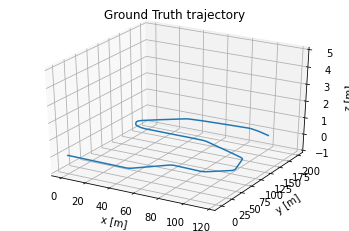

In [36]:
gt_fig = plt.figure()
ax = gt_fig.add_subplot(111, projection='3d')
ax.plot(gt.p[:,0], gt.p[:,1], gt.p[:,2])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Ground Truth trajectory')
ax.set_zlim(-1, 5)
plt.show()

## 2. Constants 

Now that our data is set up, we can start getting things ready for our solver. One of the most important aspects of a filter is setting the estimated sensor variances correctly.We set the values here.

In [37]:
var_imu_f = 0.01
var_imu_w = 0.25
var_gnss  = 0.01
var_lidar = 1.00

################################################################################################
# We can also set up some constants that won't change for any iteration of our solver.
################################################################################################
g = np.array([0, 0, -9.81])  # gravity
l_jac = np.zeros([9, 6])
l_jac[3:, :] = np.eye(6)  # motion model noise jacobian
h_jac = np.zeros([3, 9])
h_jac[:, :3] = np.eye(3)  # measurement model jacobian

## 3. Initial Values 

Set up some initial values for our ES-EKF solver.

In [38]:
p_est = np.zeros([imu_f.data.shape[0], 3])  # position estimates
p_imu = np.zeros([imu_f.data.shape[0], 3])  # position estimates depends only on IMU
v_est = np.zeros([imu_f.data.shape[0], 3])  # velocity estimates
v_imu = np.zeros([imu_f.data.shape[0], 3])  # velocity estimates depends only on IMU
q_est = np.zeros([imu_f.data.shape[0], 4])  # orientation estimates as quaternions
q_imu = np.zeros([imu_f.data.shape[0], 4])  # orientation estimates as quaternions depends only on IMU
p_cov = np.zeros([imu_f.data.shape[0], 9, 9])  # covariance matrices at each timestep

# Set initial values.
p_est[0] = gt.p[0]
p_imu[0] = gt.p[0]
v_est[0] = gt.v[0]
v_imu[0] = gt.v[0]
q_est[0] = Quaternion(euler=gt.r[0]).to_numpy()
q_imu[0] = Quaternion(euler=gt.r[0]).to_numpy()
p_cov[0] = np.zeros(9)  # covariance of estimate


## 4. Measurement Update 
Since we'll need a measurement update for both the GNSS and the LIDAR data, let's make a function for it.

In [39]:
def measurement_update(sensor_var, p_cov_check, y_k, p_check, v_check, q_check):
    # 3.1 Compute Kalman Gain
    K_k = p_cov_check@h_jac.T@inv(h_jac@p_cov_check@h_jac.T+sensor_var) #9*3


    # 3.2 Compute error state
    del_x = K_k@(y_k - p_check) #9*1

    # 3.3 Correct predicted state
    p_hat = p_check + del_x[0:3]
    v_hat = v_check + del_x[3:6]
    q_hat = Quaternion(euler=(angle_normalize(del_x[6:]))).quat_mult_left(q_check)

    # 3.4 Compute corrected covariance
    p_cov_hat = (np.eye(9)-K_k@h_jac)@p_cov_check #9*9

    return p_hat, v_hat, q_hat, p_cov_hat

## 5. Main Filter Loop 
 Now that everything is set up, we can start taking in the sensor data and creating estimates for our state in a loop.

In [40]:
i=0
n=0
countGNSS = 0
countLIDAR = 0

for k in range(1, imu_f.data.shape[0]):  # start at 1 b/c we have initial prediction from gt
    delta_t = imu_f.t[k] - imu_f.t[k - 1]

    # 1. Update state with IMU inputs
    Cns = Quaternion(*q_est[k-1]).to_mat()
    p_check = p_est[k-1] + delta_t*v_est[k-1] + delta_t**2/2*(Cns@imu_f.data[k-1]+g)
    v_check = v_est[k-1] + delta_t*(Cns@imu_f.data[k-1]+g)
    q_check = Quaternion(euler=(angle_normalize(imu_w.data[k-1]*delta_t))).quat_mult_right(q_est[k-1])
    p_cov_check = p_cov[k-1]
    
    Cns_imu = Quaternion(*q_imu[k-1]).to_mat()
    p_imu_check = p_imu[k-1] + delta_t*v_imu[k-1] + delta_t**2/2*(Cns_imu@imu_f.data[k-1]+g)
    v_imu_check = v_imu[k-1] + delta_t*(Cns_imu@imu_f.data[k-1]+g)
    q_imu_check = Quaternion(euler=(angle_normalize(imu_w.data[k-1]*delta_t))).quat_mult_right(q_imu[k-1])
    
    # C_{ns} is the rotation matrix of the q_{k-1}  quaternion.  
    # In the file rotation.py you can find a method in the Quaternion class 
    # that turns the quaternion into a rotation matrix.


    Rotation_Mat = Quaternion(*q_est[k - 1]).to_mat()
    
    # 1.1 Linearize the motion model and compute Jacobians
    F = np.eye(9)
    F[0:3,3:6] = np.eye(3)*delta_t
    F[3:6,6:9] = -skew_symmetric(Cns@imu_f.data[k-1])*delta_t

    L = np.zeros([9,6])
    L[3:6,0:3] = np.eye(3)
    L[6:,3:] = np.eye(3)
 

    # 2. Propagate uncertainty
    vf2 = var_imu_f**2
    vw2 = var_imu_w**2
    Q = np.diag([vf2, vf2, vf2, vw2, vw2, vw2])*delta_t**2
    p_cov_check = F@p_cov_check@F.T + L@Q@L.T

    # 3. Check availability of GNSS and LIDAR measurements
    # GNSS
    GNSS_flag = 0
    j=i
    while j<gnss.data.shape[0] and gnss.t[j]<=imu_f.t[k]:
        if imu_f.t[k] - gnss.t[j]==0:
            i=j
            GNSS_flag = 1
            break
        j += 1

    # LIDAR
    LIDAR_flag = 0
    m=n
    while m<lidar.data.shape[0] and lidar.t[m]<=imu_f.t[k]:
        if imu_f.t[k] - lidar.t[m]==0:
            n=m
            LIDAR_flag = 1
            break
        m += 1
    
    # Update states (save)
    if GNSS_flag == 1 and LIDAR_flag == 0:
        sensor_var = var_gnss*np.eye(3)
        y_k = gnss.data[j]
        p_hat, v_hat, q_hat, p_cov_hat = measurement_update(sensor_var, p_cov_check, y_k, p_check, v_check, q_check)
        countGNSS +=1
    elif GNSS_flag == 0 and LIDAR_flag == 1:
        sensor_var = var_lidar*np.eye(3)
        y_k = lidar.data[m]
        p_hat, v_hat, q_hat, p_cov_hat = measurement_update(sensor_var, p_cov_check, y_k, p_check, v_check, q_check)
        countLIDAR +=1
    elif GNSS_flag == 1 and LIDAR_flag == 1:
        sensor_var = var_gnss*np.eye(3)
        y_k = gnss.data[j]
        p_check0, v_check0, q_check0, p_cov_check0 = measurement_update(sensor_var, p_cov_check, y_k, p_check, v_check, q_check)
        sensor_var = var_lidar*np.eye(3)
        y_k = lidar.data[m]
        p_hat, v_hat, q_hat, p_cov_hat = measurement_update(sensor_var, p_cov_check0, y_k, p_check0, v_check0, q_check0)
        countGNSS +=1
        countLIDAR +=1
    else:
        p_hat = p_check
        v_hat = v_check
        q_hat = q_check
        p_cov_hat = p_cov_check

    p_est[k] = p_hat
    p_imu[k] = p_imu_check
    v_est[k] = v_hat
    v_imu[k] = v_imu_check
    q_est[k] = q_hat
    q_imu[k] = q_imu_check
    p_cov[k] = p_cov_hat

## 6. Results and Analysis 
Now that we have state estimates for all of our sensor data, let's plot the results. 
Before plotting the sensor fusion result, let first plot the estimation derived only from IMU dat.



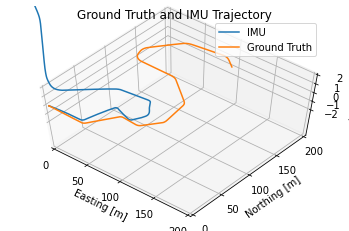

In [41]:
est_traj_fig = plt.figure()
ax = est_traj_fig.add_subplot(111, projection='3d')
ax.plot(p_imu[:,0][:8734], p_imu[:,1][:8734], p_imu[:,2][:8734], label='IMU')
ax.plot(gt.p[:,0], gt.p[:,1], gt.p[:,2], label='Ground Truth')
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_zlabel('Up [m]')
ax.set_title('Ground Truth and IMU Trajectory')
ax.set_xlim(0, 200)
ax.set_ylim(0, 200)
ax.set_zlim(-5, 2)
ax.set_xticks([0, 50, 100, 150, 200])
ax.set_yticks([0, 50, 100, 150, 200])
ax.set_zticks([-2, -1, 0, 1, 2])
ax.legend(loc=(0.62,0.77))
ax.view_init(elev=60, azim=-50)
plt.show()

Next, let plot the result for which we applied the GNSS and LiDAR data for correction.
This plot will show the ground truth and the estimated trajectories on the same plot. 

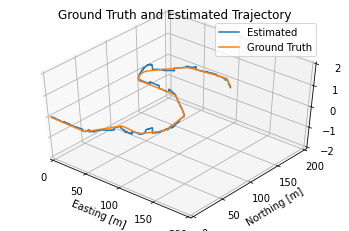

In [42]:
est_traj_fig = plt.figure()
ax = est_traj_fig.add_subplot(111, projection='3d')
ax.plot(p_est[:,0][:8734], p_est[:,1][:8734], p_est[:,2][:8734], label='Estimated')
ax.plot(gt.p[:,0], gt.p[:,1], gt.p[:,2], label='Ground Truth')
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_zlabel('Up [m]')
ax.set_title('Ground Truth and Estimated Trajectory')
ax.set_xlim(0, 200)
ax.set_ylim(0, 200)
ax.set_zlim(-2, 2)
ax.set_xticks([0, 50, 100, 150, 200])
ax.set_yticks([0, 50, 100, 150, 200])
ax.set_zticks([-2, -1, 0, 1, 2])
ax.legend(loc=(0.62,0.77))
ax.view_init(elev=45, azim=-50)
plt.show()

We can also plot the error for each of the 6 DOF, with estimates for our uncertainty included. The error estimates are in blue, and the uncertainty bounds are red and dashed. The uncertainty bounds are +/- 3 standard deviations based on our uncertainty (covariance).

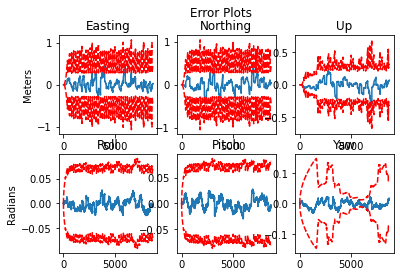

In [43]:
error_fig, ax = plt.subplots(2, 3)
error_fig.suptitle('Error Plots')
num_gt = gt.p.shape[0]
p_est_euler = []
p_cov_euler_std = []

# Convert estimated quaternions to euler angles
for i in range(len(q_est)):
    qc = Quaternion(*q_est[i, :])
    p_est_euler.append(qc.to_euler())

    # First-order approximation of RPY covariance
    J = rpy_jacobian_axis_angle(qc.to_axis_angle())
    p_cov_euler_std.append(np.sqrt(np.diagonal(J @ p_cov[i, 6:, 6:] @ J.T)))

p_est_euler = np.array(p_est_euler)
p_cov_euler_std = np.array(p_cov_euler_std)

# Get uncertainty estimates from P matrix
p_cov_std = np.sqrt(np.diagonal(p_cov[:, :6, :6], axis1=1, axis2=2))

titles = ['Easting', 'Northing', 'Up', 'Roll', 'Pitch', 'Yaw']
for i in range(3):
    ax[0, i].plot(range(num_gt), gt.p[:, i] - p_est[:num_gt, i])
    ax[0, i].plot(range(num_gt),  3 * p_cov_std[:num_gt, i], 'r--')
    ax[0, i].plot(range(num_gt), -3 * p_cov_std[:num_gt, i], 'r--')
    ax[0, i].set_title(titles[i])
ax[0,0].set_ylabel('Meters')

for i in range(3):
    ax[1, i].plot(range(num_gt), \
        angle_normalize(gt.r[:, i] - p_est_euler[:num_gt, i]))
    ax[1, i].plot(range(num_gt),  3 * p_cov_euler_std[:num_gt, i], 'r--')
    ax[1, i].plot(range(num_gt), -3 * p_cov_euler_std[:num_gt, i], 'r--')
    ax[1, i].set_title(titles[i+3])
ax[1,0].set_ylabel('Radians')
plt.show()